In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۵ — درخت‌های تصمیم و گونه‌ها
## درس ۹: پایداری درخت، واریانس، و تحلیل حساسیت

درخت‌های تصمیم سریع و قابل‌تفسیر هستند، اما درخت منفرد معمولاً **ناپایدار** است: تغییر کوچک در داده یا شرایط آموزش می‌تواند به ساختار و «توضیح» متفاوت منجر شود. این نوت‌بوک نشان می‌دهد چگونه این ناپایداری را **اندازه‌گیری** کنیم و تحلیل‌های **حساسیت** انجام دهیم که با حالت‌های شکست واقعی در پروژه‌های ML هم‌خوان باشد.

### اهداف یادگیری
- سنجش پایداری با آموزش‌های تکراری (نه فقط یک تقسیم).
- جدا کردن **پایداری عملکرد** از **پایداری توضیح**.
- استرس‌تست درخت با: نمونه‌گیری مجدد، نویز ویژگی، نویز برچسب، bootstrap، هرس، و سویپ ابرپارامترها.
- ساختن یک قالب حداقلی گزارش پایداری برای استفاده در پروژه‌ها.

### معیارهای پایداری که استفاده می‌کنیم
- شباهت جاکارد برای مجموعه ویژگی‌ها: $$J(A,B)=\frac{|A\cap B|}{|A\cup B|}$$
- همبستگی رتبه‌ای بردار اهمیت (Kendall’s $\tau$ در صورت وجود).
- توزیع معیارها (میانگین/واریانس، نه یک عدد واحد).

In [2]:
# Core scientific stack
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, r2_score

# RMSE: sklearn >= 1.4 recommends root_mean_squared_error
try:
    from sklearn.metrics import root_mean_squared_error
except Exception:
    from sklearn.metrics import mean_squared_error as _mse
    def root_mean_squared_error(y_true, y_pred):
        return _mse(y_true, y_pred, squared=False)

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Optional: Kendall tau for ranking stability (SciPy is a dependency of scikit-learn)
try:
    from scipy.stats import kendalltau
except Exception:
    kendalltau = None

from dataclasses import dataclass
from typing import Dict, List, Optional

np.random.seed(42)
print("Versions:")
import sklearn
print("  numpy:", np.__version__)
print("  pandas:", pd.__version__)
print("  sklearn:", sklearn.__version__)

Versions:
  numpy: 2.1.2
  pandas: 2.2.3
  sklearn: 1.5.2


## ۱) چرا درخت‌ها ناپایدارند (مدل ذهنی درست)

درخت‌ها با انتخاب حریصانه شکاف‌ها آموزش می‌بینند. ناپایداری اغلب وقتی رخ می‌دهد که چند شکاف کاندید **سود تقریباً برابر** داشته باشند. اغتشاش کوچک (نمونه متفاوت، نویز جزئی) می‌تواند ترتیب را عوض کند و یک شکاف اولیه را برگرداند. چون شکاف‌های اولیه زیرمسئله‌های پایین‌دست را تعیین می‌کنند، تغییر نزدیک ریشه می‌تواند به درختی کاملاً متفاوت منجر شود.

### نتیجه عملی کلیدی
پایداری دقت به این معنی نیست که توضیح‌ها (قوانین / top features) هم پایدارند. اگر تفسیرپذیری مهم است، باید پایداری توضیح را صریحاً اندازه‌گیری کنید.

### تحلیل حساسیت یعنی چه؟
ما «حساسیت» را این‌طور می‌گیریم: *خروجی‌ها تحت اغتشاش‌های کوچک چقدر تغییر می‌کنند؟* خروجی‌ها شامل:
- معیارهای ارزیابی،
- نماگرهای ساختار (عمق، برگ‌ها)،
- ویژگی‌های استفاده‌شده و اهمیت ویژگی‌ها،
- مسیرهای تصمیم محلی (کدام قانون فعال شد).

اغتشاش‌ها شامل:
- نمونه‌گیری مجدد (تقسیم‌های متفاوت / bootstrap)،
- نویز کوچک در ویژگی‌ها،
- نویز کوچک در برچسب‌ها،
- تغییر ابرپارامترها،
- تغییر شدت هرس.

In [3]:
@dataclass
class FitResult:
    seed: int
    metrics: Dict[str, float]
    used_features: List[str]
    importances: pd.Series
    tree_text: str
    y_pred: np.ndarray
    y_proba: Optional[np.ndarray] = None

def read_csv_rel(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

def jaccard(a: set, b: set) -> float:
    if not a and not b:
        return 1.0
    return len(a & b) / len(a | b)

def safe_kendall_tau(x: np.ndarray, y: np.ndarray) -> float:
    if kendalltau is None:
        return np.nan
    return float(kendalltau(x, y, nan_policy="omit").correlation)

def features_used_in_tree(tree, feature_names: List[str]) -> List[str]:
    idx = tree.feature  # -2 indicates leaf
    return sorted({feature_names[i] for i in idx if i >= 0})

def fit_tree_classifier_once(
    df: pd.DataFrame,
    target_col: str,
    seed: int,
    params: Dict,
    test_size: float = 0.25,
    stratify: bool = True,
) -> FitResult:
    X = df.drop(columns=[target_col]).copy()
    y = df[target_col].copy()

    # Encode labels (string -> int)
    if y.dtype == "object":
        y = y.astype("category").cat.codes

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=seed,
        stratify=y if stratify else None
    )

    model = DecisionTreeClassifier(random_state=seed, **params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "f1_macro": float(f1_score(y_test, y_pred, average="macro")),
        "depth": int(model.get_depth()),
        "n_leaves": int(model.get_n_leaves()),
        "n_train": int(len(X_train)),
        "n_test": int(len(X_test)),
    }

    feat_names = list(X.columns)
    used = features_used_in_tree(model.tree_, feat_names)
    importances = pd.Series(model.feature_importances_, index=feat_names).sort_values(ascending=False)
    tree_text = export_text(model, feature_names=feat_names, max_depth=4)

    return FitResult(
        seed=seed,
        metrics=metrics,
        used_features=used,
        importances=importances,
        tree_text=tree_text,
        y_pred=y_pred,
        y_proba=y_proba
    )

def stability_report(results: List[FitResult], top_k: int = 5) -> pd.DataFrame:
    rows = []
    for i in range(len(results)):
        for j in range(i + 1, len(results)):
            ri, rj = results[i], results[j]
            used_i, used_j = set(ri.used_features), set(rj.used_features)
            top_i = set(ri.importances.head(top_k).index)
            top_j = set(rj.importances.head(top_k).index)

            common = ri.importances.index.intersection(rj.importances.index)
            tau = safe_kendall_tau(ri.importances.loc[common].values, rj.importances.loc[common].values)

            rows.append({
                "seed_i": ri.seed,
                "seed_j": rj.seed,
                "jaccard_used_features": jaccard(used_i, used_j),
                "jaccard_topk_importances": jaccard(top_i, top_j),
                "kendall_tau_importances": tau,
            })
    return pd.DataFrame(rows)

def plot_metric_distribution(df_metrics: pd.DataFrame, metric: str, title: str):
    plt.figure()
    plt.hist(df_metrics[metric].values, bins=12)
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("count")
    plt.show()

## ۲) آزمایش ۱ — Iris (پایداری تحت نمونه‌گیری مجدد)

   sepal_length  sepal_width  petal_length  petal_width classification
0           5.4          3.7           1.5          0.2    Iris-setosa
1           4.8          3.4           1.6          0.2    Iris-setosa
2           4.8          3.0           1.4          0.1    Iris-setosa
3           4.3          3.0           1.1          0.1    Iris-setosa
4           5.8          4.0           1.2          0.2    Iris-setosa
Tree snapshot (seed=0):
|--- petal_width <= 0.80
|   |--- class: 0
|--- petal_width >  0.80
|   |--- petal_width <= 1.75
|   |   |--- petal_length <= 4.95
|   |   |   |--- sepal_length <= 5.05
|   |   |   |   |--- class: 1
|   |   |   |--- sepal_length >  5.05
|   |   |   |   |--- class: 1
|   |   |--- petal_length >  4.95
|   |   |   |--- class: 1
|   |--- petal_width >  1.75
|   |   |--- sepal_length <= 5.95
|   |   |   |--- class: 2
|   |   |--- sepal_length >  5.95
|   |   |   |--- class: 2



,accuracy,f1_macro,depth,n_leaves,n_train,n_test
0,0.955556,0.955357,4,6,105,45
1,0.977778,0.977753,4,6,105,45
2,0.955556,0.955357,4,7,105,45
3,0.888889,0.888765,3,5,105,45
4,0.977778,0.977753,3,5,105,45


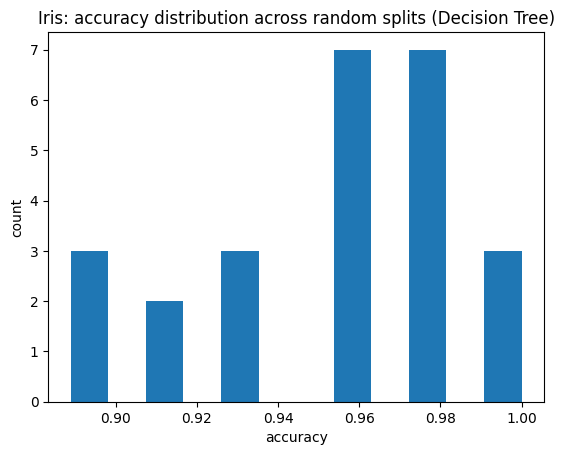

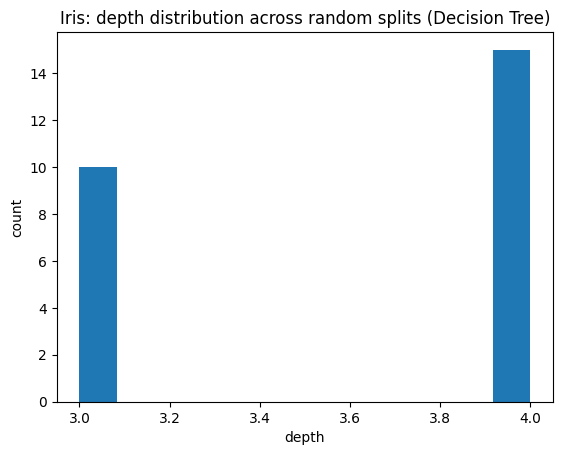

,seed_i,seed_j,jaccard_used_features,jaccard_topk_importances,kendall_tau_importances
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,7.666667,16.333333,0.798889,0.760000,0.802825
std,5.773503,5.773503,0.178037,0.250217,0.202891
min,0.000000,1.000000,0.500000,0.500000,0.333333
25%,3.000000,12.000000,0.666667,0.500000,0.600000
50%,7.000000,17.000000,0.666667,1.000000,0.912871
75%,12.000000,21.000000,1.000000,1.000000,1.000000
max,23.000000,24.000000,1.000000,1.000000,1.000000


In [4]:
# =========================
# Experiment 1 (Classification): iris.csv
# =========================
iris_path = "../../../Datasets/Classification/iris.csv"
df_iris = read_csv_rel(iris_path)
print(df_iris.head())

target_iris = "classification"
params_iris = dict(max_depth=4, min_samples_leaf=3)

seeds = list(range(0, 25))
results_iris = [fit_tree_classifier_once(df_iris, target_iris, s, params_iris, test_size=0.30) for s in seeds]

print("Tree snapshot (seed=0):")
print(results_iris[0].tree_text)

metrics_iris = pd.DataFrame([r.metrics for r in results_iris])
display(metrics_iris.head())

plot_metric_distribution(metrics_iris, "accuracy", "Iris: accuracy distribution across random splits (Decision Tree)")
plot_metric_distribution(metrics_iris, "depth", "Iris: depth distribution across random splits (Decision Tree)")

stab_iris = stability_report(results_iris, top_k=3)
display(stab_iris.describe())

## ۳) Diabetes: نویز ویژگی در برابر نویز برچسب (و رفع دقیق خطای شما)

در اجرای شما، تابع نویز برچسب این خطا را داد:

`ValueError: assignment destination is read-only`

علت این است که در برخی نسخه‌های pandas خروجی `cat.codes.to_numpy()` یک view فقط-خواندنی است.
راه‌حل: قبل از assignment با `.copy()` آن را قابل نوشتن کنید.

منطق آزمایش همان است:
- baseline با آموزش‌های تکراری،
- نویز ویژگی با آموزش‌های تکراری،
- نویز برچسب با آموزش‌های تکراری.

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age classification  
0                     0.627   50       Diabetic  
1                     0.351   31   Non-Diabetic  
2                     0.672   32       Diabetic  
3                     0.167   21   Non-Diabetic  
4                     2.288   33       Diabetic  


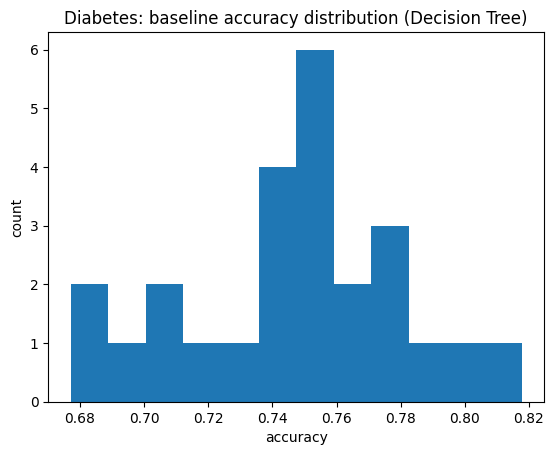

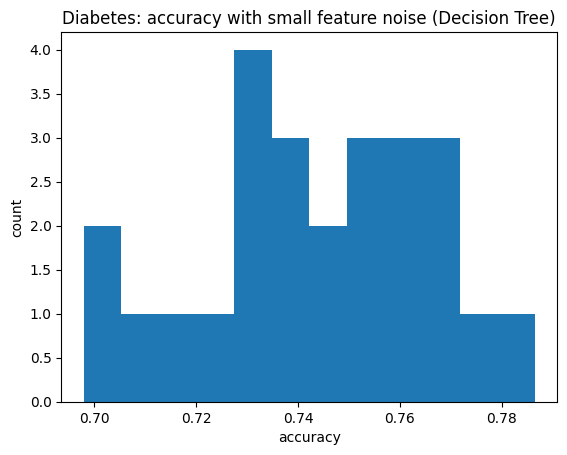

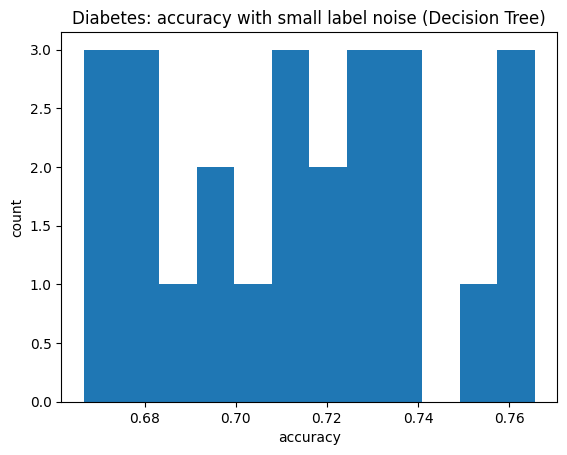

,baseline_acc,noisy_features_acc,label_noise_acc
count,25.000000,25.000000,25.000000
mean,0.746458,0.743750,0.713958
std,0.034735,0.022703,0.030478
min,0.677083,0.697917,0.666667
25%,0.729167,0.729167,0.687500
50%,0.750000,0.744792,0.713542
75%,0.765625,0.760417,0.734375
max,0.817708,0.786458,0.765625


In [5]:
# =========================
# Experiment 2 (Classification + perturbation): diabetes.csv
# =========================
diabetes_path = "../../../Datasets/Classification/diabetes.csv"
df_diabetes = read_csv_rel(diabetes_path)
print(df_diabetes.head())

target_diabetes = "classification"
numeric_cols = [c for c in df_diabetes.columns if c != target_diabetes]

params_diabetes = dict(max_depth=5, min_samples_leaf=10)

def add_feature_noise(df: pd.DataFrame, cols: List[str], seed: int, noise_scale: float = 0.05) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    out = df.copy()
    for c in cols:
        if pd.api.types.is_numeric_dtype(out[c]):
            std = out[c].std(ddof=0)
            out[c] = out[c] + rng.normal(0.0, noise_scale * (std if std > 0 else 1.0), size=len(out))
    return out


def flip_labels(df: pd.DataFrame, target: str, seed: int, frac: float = 0.03) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    out = df.copy()
    n = len(out)
    k = max(1, int(frac * n))
    idx = rng.choice(n, size=k, replace=False)

    y = out[target].astype("category")
    # IMPORTANT: .copy() makes the array writable (fixes "assignment destination is read-only")
    codes = y.cat.codes.to_numpy().copy()
    n_classes = len(y.cat.categories)

    if n_classes == 2:
        codes[idx] = 1 - codes[idx]
    else:
        codes[idx] = rng.integers(0, n_classes, size=k)

    out[target] = pd.Categorical.from_codes(codes, y.cat.categories)
    return out

seeds = list(range(0, 25))

baseline_results = [fit_tree_classifier_once(df_diabetes, target_diabetes, s, params_diabetes, test_size=0.25) for s in seeds]
baseline_metrics = pd.DataFrame([r.metrics for r in baseline_results])
plot_metric_distribution(baseline_metrics, "accuracy", "Diabetes: baseline accuracy distribution (Decision Tree)")

noisy_results = [fit_tree_classifier_once(add_feature_noise(df_diabetes, numeric_cols, s), target_diabetes, s, params_diabetes, test_size=0.25) for s in seeds]
noisy_metrics = pd.DataFrame([r.metrics for r in noisy_results])
plot_metric_distribution(noisy_metrics, "accuracy", "Diabetes: accuracy with small feature noise (Decision Tree)")

label_noise_results = [fit_tree_classifier_once(flip_labels(df_diabetes, target_diabetes, s, frac=0.04), target_diabetes, s, params_diabetes, test_size=0.25) for s in seeds]
label_noise_metrics = pd.DataFrame([r.metrics for r in label_noise_results])
plot_metric_distribution(label_noise_metrics, "accuracy", "Diabetes: accuracy with small label noise (Decision Tree)")

summary = pd.DataFrame({
    "baseline_acc": baseline_metrics["accuracy"],
    "noisy_features_acc": noisy_metrics["accuracy"],
    "label_noise_acc": label_noise_metrics["accuracy"],
})
display(summary.describe())

## ۴) آزمایش ۳ — Drug200 (ویژگی‌های دسته‌ای + OneHot)

   Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  DrugY
1   47   M     LOW        HIGH   13.093  drugC
2   47   M     LOW        HIGH   10.114  drugC
3   28   F  NORMAL        HIGH    7.798  drugX
4   61   F     LOW        HIGH   18.043  DrugY


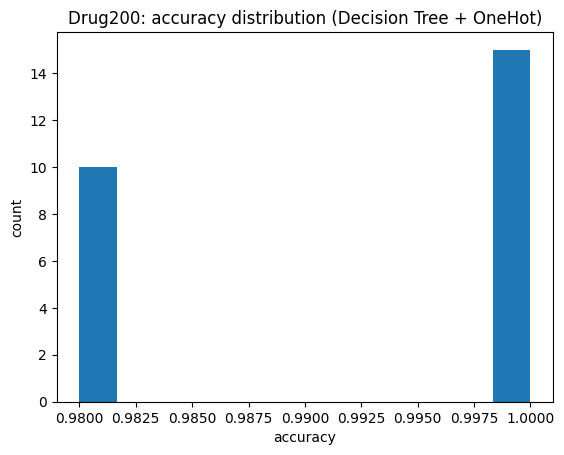

,seed_i,seed_j,jaccard_used_features,jaccard_topk_importances,kendall_tau_importances
count,300.000000,300.000000,300.000000,300.0,300.000000
mean,7.666667,16.333333,0.681905,1.0,0.759222
std,5.773503,5.773503,0.206473,0.0,0.149445
min,0.000000,1.000000,0.428571,1.0,0.566667
25%,3.000000,12.000000,0.428571,1.0,0.566667
50%,7.000000,17.000000,0.666667,1.0,0.766667
75%,12.000000,21.000000,0.666667,1.0,0.833333
max,23.000000,24.000000,1.000000,1.0,1.000000


In [6]:
# =========================
# Experiment 3 (Categorical features): drug200.csv
# =========================
drug_path = "../../../Datasets/Classification/drug200.csv"
df_drug = read_csv_rel(drug_path)
print(df_drug.head())

target_drug = "Drug"
X = df_drug.drop(columns=[target_drug]).copy()
y = df_drug[target_drug].astype("category").cat.codes

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

def fit_drug_once(seed: int):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=seed, stratify=y
    )
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("tree", DecisionTreeClassifier(random_state=seed, max_depth=6, min_samples_leaf=8))
    ])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    acc = float(accuracy_score(y_test, pred))
    f1 = float(f1_score(y_test, pred, average="macro"))

    feat_names = pipe.named_steps["preprocess"].get_feature_names_out()
    importances = pd.Series(pipe.named_steps["tree"].feature_importances_, index=feat_names).sort_values(ascending=False)

    used_idx = pipe.named_steps["tree"].tree_.feature
    used = sorted({feat_names[i] for i in used_idx if i >= 0})
    tree_text = export_text(pipe.named_steps["tree"], feature_names=list(feat_names), max_depth=3)

    return FitResult(seed=seed, metrics={"accuracy": acc, "f1_macro": f1}, used_features=used,
                     importances=importances, tree_text=tree_text, y_pred=pred)

seeds = list(range(0, 25))
results_drug = [fit_drug_once(s) for s in seeds]
metrics_drug = pd.DataFrame([r.metrics for r in results_drug])
plot_metric_distribution(metrics_drug, "accuracy", "Drug200: accuracy distribution (Decision Tree + OneHot)")

stab_drug = stability_report(results_drug, top_k=10)
display(stab_drug.describe())

## ۵) آزمایش ۴ — House Prices (واریانس رگرسیون + پیچیدگی)

   Home   Price  SqFt  Bedrooms  Bathrooms  Offers Brick Neighborhood
0     1  114300  1790         2          2       2    No         East
1     2  114200  2030         4          2       3    No         East
2     3  114800  1740         3          2       1    No         East
3     4   94700  1980         3          2       3    No         East
4     5  119800  2130         3          3       3    No         East


,max_depth,rmse_mean,rmse_std,mae_mean,r2_mean
0,2,16685.873325,2137.135817,13109.316612,0.544484
1,3,15664.032799,1577.898472,12558.175739,0.582070
2,4,15028.234170,1951.687328,11782.864632,0.629469
3,5,14747.140523,2128.265722,11426.771589,0.644886
4,6,15125.765010,2293.103451,11710.983173,0.626898
5,8,15004.300746,1094.233608,11451.284371,0.625673
6,10,15133.922270,1942.021141,11528.205128,0.628325


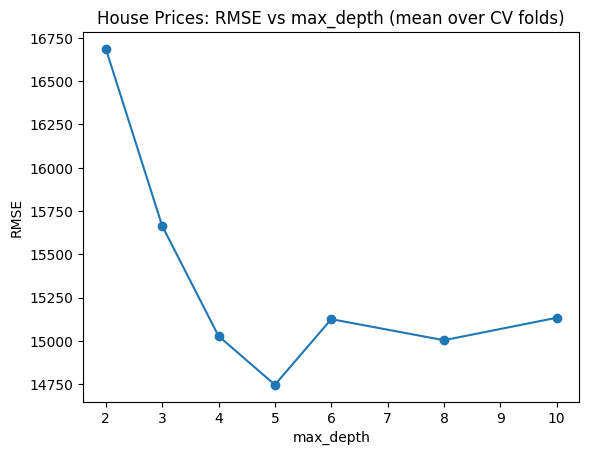

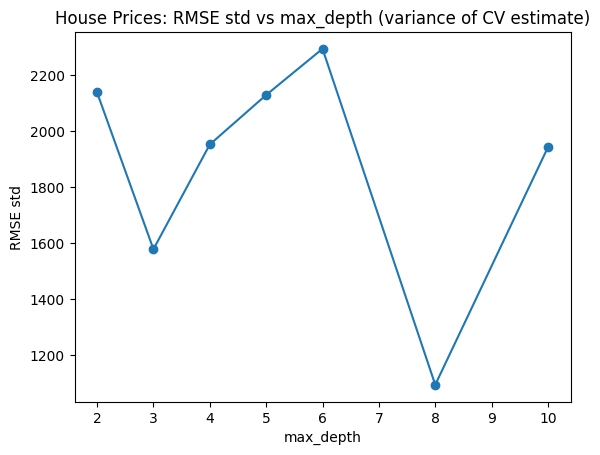

In [7]:
# =========================
# Experiment 4 (Regression tree): house-prices.csv
# =========================
hp_path = "../../../Datasets/Regression/house-prices.csv"
df_hp = read_csv_rel(hp_path)
print(df_hp.head())

target_hp = "Price"
X_hp = df_hp.drop(columns=[target_hp]).copy()
y_hp = df_hp[target_hp].astype(float)

cat_cols = [c for c in X_hp.columns if X_hp[c].dtype == "object"]
num_cols = [c for c in X_hp.columns if c not in cat_cols]

preprocess_hp = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

def eval_reg_tree_depths(depths=(2,3,4,5,6,8,10), seed=42):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    rows = []
    for max_depth in depths:
        rmses, maes, r2s = [], [], []
        for tr, te in kf.split(X_hp):
            Xtr, Xte = X_hp.iloc[tr], X_hp.iloc[te]
            ytr, yte = y_hp.iloc[tr], y_hp.iloc[te]

            model = Pipeline([
                ("preprocess", preprocess_hp),
                ("tree", DecisionTreeRegressor(random_state=seed, max_depth=max_depth, min_samples_leaf=2))
            ])
            model.fit(Xtr, ytr)
            pred = model.predict(Xte)

            rmse = root_mean_squared_error(yte, pred)
            mae = mean_absolute_error(yte, pred)
            r2 = r2_score(yte, pred)

            rmses.append(rmse); maes.append(mae); r2s.append(r2)

        rows.append({
            "max_depth": max_depth,
            "rmse_mean": float(np.mean(rmses)),
            "rmse_std": float(np.std(rmses, ddof=1)),
            "mae_mean": float(np.mean(maes)),
            "r2_mean": float(np.mean(r2s)),
        })
    return pd.DataFrame(rows)

depth_curve = eval_reg_tree_depths()
display(depth_curve)

plt.figure()
plt.plot(depth_curve["max_depth"], depth_curve["rmse_mean"], marker="o")
plt.title("House Prices: RMSE vs max_depth (mean over CV folds)")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.show()

plt.figure()
plt.plot(depth_curve["max_depth"], depth_curve["rmse_std"], marker="o")
plt.title("House Prices: RMSE std vs max_depth (variance of CV estimate)")
plt.xlabel("max_depth")
plt.ylabel("RMSE std")
plt.show()

## ۶) جعبه‌ابزار حساسیت: permutation importance + partial dependence

Reference accuracy: 0.75


Glucose                     0.164583
BMI                         0.036875
Age                         0.029167
Insulin                     0.023333
BloodPressure               0.006042
Pregnancies                 0.005833
SkinThickness               0.000000
DiabetesPedigreeFunction    0.000000
dtype: float64

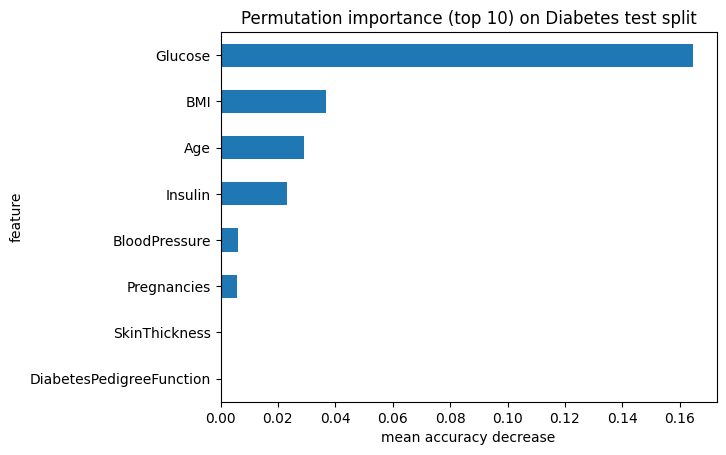

<Figure size 640x480 with 0 Axes>

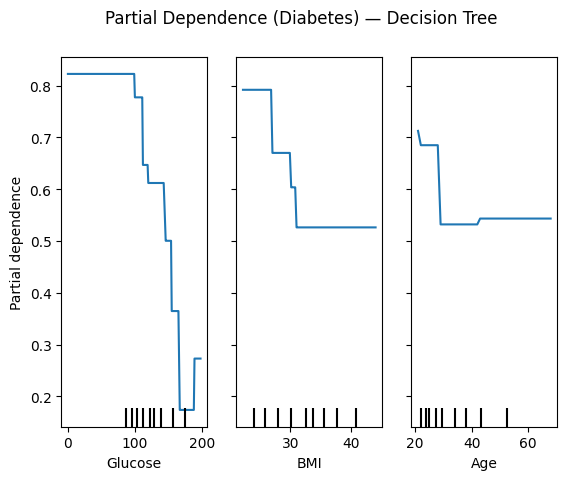

In [8]:
# =========================
# Sensitivity toolkit: permutation importance and partial dependence (Diabetes)
# =========================
seed = 7
# Ensure df_diabetes is available even if you run this cell before the Diabetes experiment
if "df_diabetes" not in globals() or "target_diabetes" not in globals():
    diabetes_path = "../../../Datasets/Classification/diabetes.csv"
    df_diabetes = read_csv_rel(diabetes_path)
    target_diabetes = "classification"

X = df_diabetes.drop(columns=[target_diabetes]).copy()
y = df_diabetes[target_diabetes].astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed, stratify=y)

ref_tree = DecisionTreeClassifier(random_state=seed, max_depth=5, min_samples_leaf=10)
ref_tree.fit(X_train, y_train)
pred = ref_tree.predict(X_test)
print("Reference accuracy:", accuracy_score(y_test, pred))

perm = permutation_importance(ref_tree, X_test, y_test, scoring="accuracy", n_repeats=25, random_state=seed)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
display(perm_imp.head(10))

plt.figure()
perm_imp.head(10).iloc[::-1].plot(kind="barh")
plt.title("Permutation importance (top 10) on Diabetes test split")
plt.xlabel("mean accuracy decrease")
plt.ylabel("feature")
plt.show()

features_for_pdp = ["Glucose", "BMI", "Age"]
plt.figure()
PartialDependenceDisplay.from_estimator(ref_tree, X_test, features=features_for_pdp, target=1)
plt.suptitle("Partial Dependence (Diabetes) — Decision Tree")
plt.show()

## ۴) قالب حداقلی گزارش پایداری (بدون تکرار)

وقتی مدل درخت را مستندسازی می‌کنید، هم پایداری پیش‌بینی و هم پایداری توضیح را گزارش دهید.

### قالب پیشنهادی
۱) **داده و snapshot**
   - مسیر دیتاست + تعداد سطر/ستون
   - تعریف هدف و پیش‌پردازش
۲) **دستور مدل**
   - ابرپارامترها (`max_depth`، `min_samples_leaf`، `ccp_alpha`)
   - seedهای استفاده‌شده
۳) **توزیع عملکرد**
   - میانگین/انحراف معیار (یا کوانتیل‌ها) برای دقت/RMSE در تکرارها
۴) **پایداری توضیح**
   - میانه شباهت جاکارد مجموعه ویژگی‌های استفاده‌شده
   - پایداری top-$k$ importance (جاکارد + Kendall $\tau$ در صورت نیاز)
۵) **استرس‌تست**
   - نویز ویژگی، نویز برچسب، و توافق bootstrap (test ثابت)
۶) **تصمیم و محدودیت‌ها**
   - چه مقدار ناپایداری برای کاربرد قابل قبول است و چرا

این بخش عمداً کوتاه است تا یک پاراگراف تکراری چندین‌بار تکرار نشود.

In [9]:
# =========================
# Exercises (starter code)
# =========================
# 1) Replicate stability study on glass.csv (target: Type) or stars.csv (target: Type).
# 2) Sweep min_samples_leaf and measure (a) accuracy distribution and (b) feature-set Jaccard stability.
# 3) Bootstrap stability with B>=200 on a fixed test set and report agreement distribution.
# 4) Local what-if: find smallest perturbation (single feature) that flips prediction for a chosen point.